In [73]:
num_positives = 8
num_negatives_per_positive = 5

In [74]:
# Load entire corpus
import json
def load_jsonl(path):
    with open(path) as f:
        return [json.loads(i) for i in f.readlines()]
        
corpus = load_jsonl("/gallery_louvre/dayoon.ko/research/sds/src/datasets/trec-covid/corpus.jsonl")
corpus_dict = {}
for item in corpus:
    corpus_dict[item["_id"]] = item["text"]

In [87]:
# Load succ and fail csv files
import pandas as pd
succ_path = "/gallery_louvre/dayoon.ko/research/sds/retrieval/results/multilingual-e5-large/trec-covid-suc.csv"
fail_path = "/gallery_louvre/dayoon.ko/research/sds/retrieval/results/multilingual-e5-large/trec-covid-fail.csv"
succ_df = pd.read_csv(succ_path)
fail_df = pd.read_csv(fail_path)

# Get succ and fail corpus-id
succ_ids = succ_df["corpus-id"].values
fail_ids = fail_df["corpus-id"].values

# Get succ and fail documents
succ_docs = [corpus_dict[i] for i in succ_ids]
fail_docs = [corpus_dict[i] for i in fail_ids]

len(succ_ids), len(fail_ids)

(89, 38)

In [31]:
def get_positives(path):
    path = path.replace(".csv", "-d2d-retrieval.jsonl")
    d2d_ret = load_jsonl(path)
    positives = []
    for d2d in d2d_ret:
        positive = []
        for ret in d2d["retrieval"]:
            doc = ret["document"]
            if doc != d2d["text"]:
                positive.append(doc)
            if len(positive) == num_positives:
                positives.append(positive)
                break
    return positives

succ_positives = get_positives(succ_path)
fail_positives = get_positives(fail_path)

In [32]:
def get_negatives(path):
    # Load d2d
    d2d_path = path.replace(".csv", "-d2d-retrieval.jsonl")
    d2d_ret = load_jsonl(d2d_path)
    d2d_text = [[i["document"] for i in ret["retrieval"]]
                    for ret in d2d_ret]
    # Load d2d2d
    d2d2d_path = path.replace(".csv", "-d2d2d-retrieval.jsonl")
    d2d2d_ret = load_jsonl(d2d2d_path)
    d2d2d_ret_batches = [d2d2d_ret[i:i+num_positives] for i in range(0, len(d2d2d_ret), num_positives)] # 89, n_pos, n_neg
    
    # Select negatives
    negatives_total = [] # per datapoint
    for first_ret, second_ret_batch in zip(d2d_text, d2d2d_ret_batches):
        negatives = [] # per positive
        for second_ret in second_ret_batch:
            negative = []
            second_ret = [i["document"] for i in second_ret["retrieval"]]
            for ret in second_ret:
                if ret not in first_ret:
                    negative.append(ret)
                if len(negative) == num_negatives_per_positive:
                    negatives.append(negative)
                    break
            if len(negative) < num_negatives_per_positive:
                negatives.append(negative)
        negatives_total.append(negatives)
            
    return negatives_total

succ_negatives = get_negatives(succ_path)
fail_negatives = get_negatives(fail_path)

In [33]:
def generate_dataset(docs, positives, negatives):
    dataset = []
    for i in range(len(docs)):
        query = docs[i]
        positives_selected = []
        negatives_selected = []
        for j, doc in enumerate(positives[i]):
            if len(negatives[i][j]) == num_negatives_per_positive:
                positives_selected.append(doc)
                negatives_selected.append(negatives[i][j])
            if len(positives_selected) == 4:
                break
        for p, ns in zip(positives_selected, negatives_selected):
            dataset.append({
                "query": query,
                "pos": [p],
                "neg": ns
            })
    return dataset

In [34]:
succ_dataset = generate_dataset(succ_docs, succ_positives, succ_negatives)
print(succ_dataset[0])
with open("trec-covid/ood_well_below_0.4.json", "w") as f:
    json.dump(succ_dataset, f, indent=2)

{'query': 'SARS-CoV-2 has caused tens of thousands of infections and more than one thousand deaths. There are currently no registered therapies for treating coronavirus infections. Because of time consuming process of new drug development, drug repositioning may be the only solution to the epidemic of sudden infectious diseases. We systematically analyzed all the proteins encoded by SARS-CoV-2 genes, compared them with proteins from other coronaviruses, predicted their structures, and built 19 structures that could be done by homology modeling. By performing target-based virtual ligand screening, a total of 21 targets (including two human targets) were screened against compound libraries including ZINC drug database and our own database of natural products. Structure and screening results of important targets such as 3-chymotrypsin-like protease (3CLpro), Spike, RNA-dependent RNA polymerase (RdRp), and papain like protease (PLpro) were discussed in detail. In addition, a database of 78

In [170]:
fail_dataset = generate_dataset(fail_docs, fail_positives, fail_negatives)
print(fail_dataset[0])
with open("ood_dataset/trec-covid-fail.json", "w") as f:
    json.dump(fail_dataset, f, indent=2)

{'query': "Abstract COVID-19 was originated from Wuhan city of Hubei Province in China in December 2019. Since then it has spread in more than 210 countries and territories. It is a viral disease due to the Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) virus. The patients show flu-like symptoms with a dry cough, sore throat, high fever, and breathing problems. The disease due to SARS-CoV-2 was named as COVID-19. About 2.2 million people have been infected with more than 0.15 million deaths globally. The United States of America is the most affected country with the highest patients of about 0.7 million. Despite great efforts, there is no treatment of this disease. However, prevention and management are the best options. This article describes SARS-CoV-2, disease, prevention and management, treatment and social impact on society. It was analyzed that a combination of antiviral drugs with hydroxyl-chloroquine and azithromycin (with the consultation of a medical practitione

# Random negative

In [9]:
import random

negs = [i["text"] for i in random.sample(corpus, 20) if len(i["text"]) > 0][:5]

def generate_rand_neg_dataset(docs, positives, negatives):
    dataset = []
    for i in range(len(docs)):
        query = docs[i]
        positives_selected = []
        negatives_selected = []
        for j, doc in enumerate(positives[i]):
            if len(negatives[i][j]) == num_negatives_per_positive:
                positives_selected.append(doc)
                negatives_selected.append(negs)
            if len(positives_selected) == 4:
                break
        for p, ns in zip(positives_selected, negatives_selected):
            dataset.append({
                "query": query,
                "pos": [p],
                "neg": ns
            })
    return dataset

In [10]:
succ_dataset = generate_rand_neg_dataset(succ_docs, succ_positives, succ_negatives)
print(succ_dataset[0])
with open("id_randneg_dataset/trec-covid-succ.json", "w") as f:
    json.dump(succ_dataset, f, indent=2)


fail_dataset = generate_rand_neg_dataset(fail_docs, fail_positives, fail_negatives)
print(fail_dataset[0])
with open("ood_randneg_dataset/trec-covid-fail.json", "w") as f:
    json.dump(fail_dataset, f, indent=2)

{'query': 'SARS-CoV-2 has caused tens of thousands of infections and more than one thousand deaths. There are currently no registered therapies for treating coronavirus infections. Because of time consuming process of new drug development, drug repositioning may be the only solution to the epidemic of sudden infectious diseases. We systematically analyzed all the proteins encoded by SARS-CoV-2 genes, compared them with proteins from other coronaviruses, predicted their structures, and built 19 structures that could be done by homology modeling. By performing target-based virtual ligand screening, a total of 21 targets (including two human targets) were screened against compound libraries including ZINC drug database and our own database of natural products. Structure and screening results of important targets such as 3-chymotrypsin-like protease (3CLpro), Spike, RNA-dependent RNA polymerase (RdRp), and papain like protease (PLpro) were discussed in detail. In addition, a database of 78

# Succ hard selection

In [104]:
succ_df_selected = succ_df[succ_df["tp_over_t"] < 0.35]
succ_ids_selected = succ_df_selected.index.tolist()
succ_docs_selected = [succ_docs[i] for i  in succ_ids_selected]
succ_df_selected

,Unnamed: 0,corpus-id,num-positive-query-gt,tp_over_t,tp_over_p
0,1675,i1lyno9g,4,0.250000,1.0
1,2067,xpbcoipf,4,0.250000,1.0
2,2032,gmk4qo4i,4,0.250000,0.5
3,2021,lysvg3vw,4,0.250000,1.0
4,2010,r0gr0bhl,4,0.250000,1.0
...,...,...,...,...,...
65,905,jc9ugexn,4,0.250000,1.0
66,906,vxqdfiel,4,0.250000,1.0
67,898,7y87ktmi,4,0.250000,1.0
68,945,eitnkdi9,4,0.250000,0.5


In [96]:
succ_positives = get_positives(succ_path)
succ_positives_selected = [succ_positives[i] for i in succ_ids_selected]

In [97]:
succ_negatives = get_negatives(succ_path)
succ_negatives_selected = [succ_negatives[i] for i in succ_ids_selected]

In [98]:
def generate_dataset(docs, positives, negatives):
    dataset = []
    for i in range(len(docs)):
        query = docs[i]
        positives_selected = []
        negatives_selected = []
        for j, doc in enumerate(positives[i]):
            if len(negatives[i][j]) == num_negatives_per_positive:
                positives_selected.append(doc)
                negatives_selected.append(negatives[i][j])
            if len(positives_selected) == 4:
                break
        for p, ns in zip(positives_selected, negatives_selected):
            dataset.append({
                "query": query,
                "pos": [p],
                "neg": ns
            })
    return dataset


In [99]:
succ_dataset_selected = generate_dataset(succ_docs_selected, succ_positives_selected, succ_negatives_selected)
print(succ_dataset_selected[0])
with open("trec-covid/ood_well_over_0.4.json", "w") as f:
    json.dump(succ_dataset_selected, f, indent=2)

{'query': 'Importance: The pandemic of coronavirus disease 2019 (COVID-19) caused by the novel severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) presents an unprecedented challenge to identify effective drugs for prevention and treatment. Given the rapid pace of scientific discovery and clinical data generated by the large number of people rapidly infected by SARS-CoV-2, clinicians need accurate evidence regarding effective medical treatments for this infection. Observations: No proven effective therapies for this virus currently exist. The rapidly expanding knowledge regarding SARS-CoV-2 virology provides a significant number of potential drug targets. The most promising therapy is remdesivir. Remdesivir has potent in vitro activity against SARS-CoV-2, but it is not US Food and Drug Administration approved and currently is being tested in ongoing randomized trials. Oseltamivir has not been shown to have efficacy, and corticosteroids are currently not recommended. Current cl

# Plot grad norm result

err
err
err
err
err


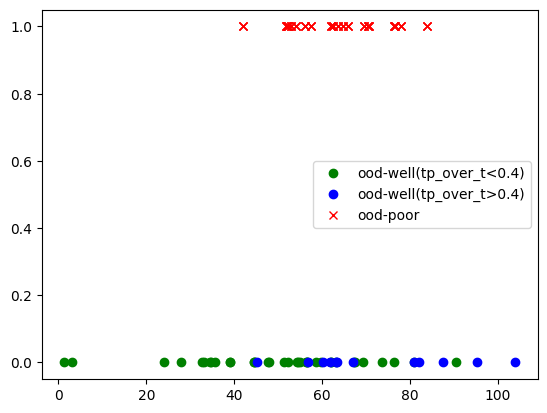

In [111]:
pth = "/gallery_louvre/dayoon.ko/research/sds/FlagEmbedding/FlagEmbedding/BGE_M3/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 

def get_score_list(pth):
    lines = load_file(pth)
    gns = []
    for l in lines:
        try:
            sid = l.index("tensor(") + len("tensor(") 
            eid = sid + 5
            gns.append(float(l[sid:eid]))
        except:
            print("err")
            continue
    return gns 
    
ood_well_pth_o = pth + "id_o"
ood_well_o = get_score_list(ood_well_pth_o)

ood_well_pth_b = pth + "id_b"
ood_well_b = get_score_list(ood_well_pth_b)

ood_poor_pth = pth + "ood"
ood_poor = get_score_list(ood_poor_pth)

import matplotlib.pyplot as plt 
plt.figure()
plt.plot(ood_well_b, len(ood_well_b) * [0], "o" , label = "ood-well(tp_over_t<0.4)", color="green")
plt.plot(ood_well_o, len(ood_well_o) * [0], "o" , label = "ood-well(tp_over_t>0.4)", color="blue")
plt.plot(ood_poor, len(ood_poor) * [1], "x" , label = "ood-poor", color="red")
plt.legend()
 